# Gaussian Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Random

using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

## MCHMC

In [3]:
d = 100
k = 1000
m = Vector(LinRange(1, 100, d))
e = 10 .^ LinRange(log10(1/sqrt(k)), log10(sqrt(k)), d)
cov_matt = Diagonal(e);

In [4]:
sqrt(d)*sqrt(minimum(e))

1.7782794100389228

In [5]:
target = GaussianTarget(m, cov_matt);

In [6]:
spl = MCHMC(30_000, 0.001; init_eps=sqrt(d), sigma=ones(d));
@time samples_mchmc = Sample(spl, target, 70_000; dialog=true);

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: UndefVarError: `progress` not defined

In [7]:
_samples_mchmc = mapreduce(permutedims, vcat, samples_mchmc[10_000:end])
stds = std(_samples_mchmc, dims=1)[1:end-3]
means = mean(_samples_mchmc, dims=1)[1:end-3]
E = [sample[end-1] for sample in samples_mchmc][10_000:end];
VarE = mean(E.^2)/d

LoadError: UndefVarError: `samples_mchmc` not defined

In [8]:
ESSs, rhat = Summarize(samples_mchmc[10_000:end])
ESS = mean(ESSs)

LoadError: UndefVarError: `samples_mchmc` not defined

In [9]:
plt.plot(E/d, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE, digits=5)))

LoadError: UndefVarError: `E` not defined

In [10]:
spl = MCHMC(30_000, 0.001; init_eps=sqrt(d), adaptive=true, sigma=ones(d))
@time samples_mchmc_adaptive = Sample(spl, target, 70_000; dialog=true);

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: UndefVarError: `progress` not defined

In [11]:
_samples_mchmc_adaptive = mapreduce(permutedims, vcat, samples_mchmc_adaptive[10_000:end])
stds_adaptive = std(_samples_mchmc_adaptive, dims=1)[1:end-3]
means_adaptive = mean(_samples_mchmc_adaptive, dims=1)[1:end-3]
E_adaptive = [sample[end-1] for sample in samples_mchmc_adaptive]#[10_000:end];
eps_adaptive = [sample[end-2] for sample in samples_mchmc_adaptive]#[10_000:end]
VarE_adaptive = mean(E_adaptive.^2)/d

LoadError: UndefVarError: `samples_mchmc_adaptive` not defined

In [12]:
ESSs, rhat = Summarize(samples_mchmc_adaptive[10_000:end])
ESS = mean(ESSs)

LoadError: UndefVarError: `samples_mchmc_adaptive` not defined

In [13]:
plt.plot(E_adaptive/d, label="E/d")
plt.ylabel("E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE_adaptive, digits=5)))

LoadError: UndefVarError: `E_adaptive` not defined

In [14]:
plt.plot(eps_adaptive, label="eps")
plt.ylabel("eps")
plt.title(string("d = ", d))

LoadError: UndefVarError: `eps_adaptive` not defined

In [15]:
stds

LoadError: UndefVarError: `stds` not defined

In [16]:
plt.plot(Vector(1:d), zeros(d), "k--")
plt.plot(Vector(1:d), stds./sqrt.(e) .- 1, label="MCHMC stds comp.", alpha=0.7)
plt.plot(Vector(1:d), stds_adaptive./sqrt.(e) .- 1, label="Adaptive MCHMC stds comp.", alpha=0.7)
plt.legend()
plt.title(string("d=", d));

LoadError: UndefVarError: `stds` not defined

In [17]:
plt.plot(Vector(1:d), zeros(d), "k--")
plt.plot(Vector(1:d), (means .- m)./sqrt.(e), label="MCHMC means comp.", alpha=0.7)
plt.plot(Vector(1:d), (means_adaptive .- m)./sqrt.(e), label="Adaptive MCHMC means comp.", alpha=0.7)
plt.legend()
plt.title(string("d=", d));

LoadError: UndefVarError: `means` not defined

## NUTS

In [18]:
using AdvancedHMC
using LogDensityProblems

In [19]:
# Define the target distribution using the `LogDensityProblem` interface
struct LogTargetDensity
    dim::Int
end
LogDensityProblems.logdensity(p::LogTargetDensity, θ) = -target.nlogp(θ) #-sum(abs2, θ) / 2  # standard multivariate normal
LogDensityProblems.dimension(p::LogTargetDensity) = p.dim
LogDensityProblems.capabilities(::Type{LogTargetDensity}) = LogDensityProblems.LogDensityOrder{0}()

In [20]:
# Choose parameter dimensionality and initial parameter value
initial_θ = target.prior_draw()
ℓπ = LogTargetDensity(d)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 10_000, 10_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(d)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = AdvancedHMC.Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples_hmc, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:00:07
  iterations:                    10000
  n_steps:                       15
  is_accept:                     true
  acceptance_rate:               0.9125526687484303
  log_density:                   -145.05953685152375
  hamiltonian_energy:            199.35177777076495
  hamiltonian_energy_error:      0.021617147514803037
  max_hamiltonian_energy_error:  0.19574185128277577
  tree_depth:                    4
  numerical_error:               false
  step_size:                     0.34450114613008137
  nom_step_size:                 0.3445

In [21]:
_samples_hmc = mapreduce(permutedims, vcat, samples_hmc)
stds_hmc = vec(std(_samples_hmc, dims=1))
means_hmc = vec(mean(_samples_hmc, dims=1));

In [22]:
ESSs, rhat = Summarize(samples_hmc)
ESS = mean(ESSs)

3938.9989495467958

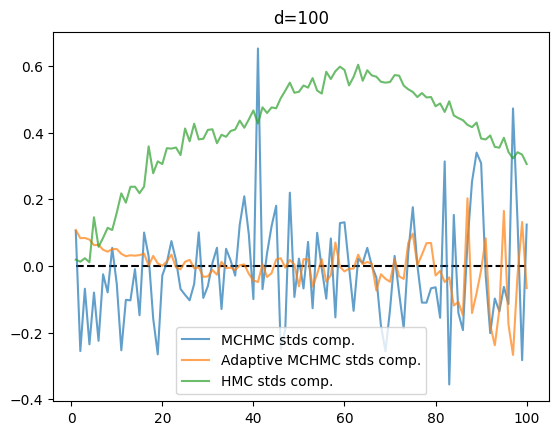

In [27]:
plt.plot(Vector(1:d), zeros(d), "k--")
plt.plot(Vector(1:d), stds./sqrt.(e) .- 1, label="MCHMC stds comp.", alpha=0.7)
plt.plot(Vector(1:d), stds_adaptive./sqrt.(e) .- 1, label="Adaptive MCHMC stds comp.", alpha=0.7)
plt.plot(Vector(1:d), stds_hmc./sqrt.(e) .- 1, label="HMC stds comp.", alpha=0.7)
plt.legend()
plt.title(string("d=", d));

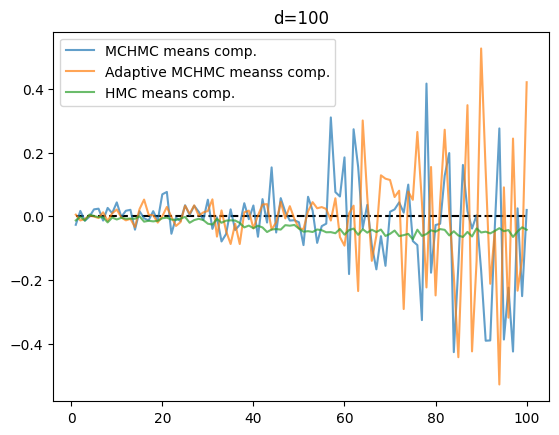

In [28]:
plt.plot(Vector(1:d), zeros(d), "k--")
plt.plot(Vector(1:d), (means .- m) ./ sqrt.(e), label="MCHMC means comp.", alpha=0.7)
plt.plot(Vector(1:d), (means_adaptive.- m) ./ sqrt.(e), label="Adaptive MCHMC meanss comp.", alpha=0.7)
plt.plot(Vector(1:d), (means_hmc.- m) ./ sqrt.(e), label="HMC means comp.", alpha=0.7)
plt.legend()
plt.title(string("d=", d));